In [1]:
from __future__ import print_function
import torchvision
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
###############
import torchvision.models as models
import imageio
from torch import autograd
from torchvision.utils import make_grid
import imageio
from IPython.display import HTML
import time
import math
manualseed = 47
random.seed(manualseed)
torch.manual_seed(manualseed)
import torch.nn.functional as F
###############
%matplotlib inline

2 Define variables

In [2]:
workers = 2 # 数据加载器能够使用的进程数量
batch_size = 64  # 训练时的批大小
weight_decay = 1e-5
# 训练图片的大小，所有的图片都将改变到该大小
image_size = 32  # 转换器使用的大小.
nc = 3  # 训练图片的通道数，彩色图片是3
nz = 100  # 本征向量z的大小(生成器的输入大小)
ngf = 32  # 生成器中特征图个数大小
ndf = 64  # 判别器中特征图个数大小
num_epochs = 50
lr = 0.0002  # 优化器学习率
beta1 = 0.5  # Adam优化器的Beta1超参
ngpu = 1  # 可利用的GPU数量，使用0将运行在CPU模式。
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

3 创建数据集

In [3]:

################这里可不要，修改后放到下面了#################
# 创建数据集
dataset = torchvision.datasets.CIFAR10(root='C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\MNIST_data', train=True, transform=transforms.Compose([transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5,)),
                           ]), download=False)
# 创建数据加载器
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)  #600*100*([[28*28],x])



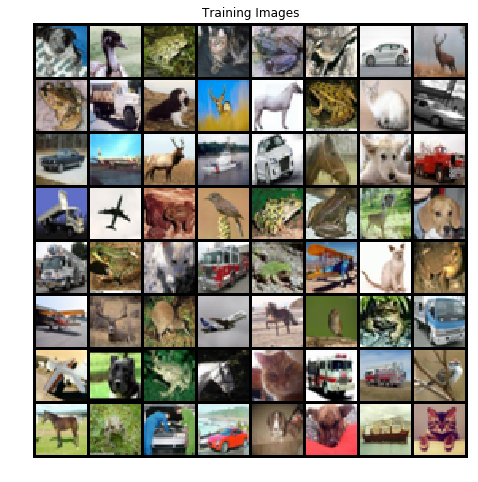

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        self.ngpu = ngpu
        super(Generator,self).__init__()
        self.gen=nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(110, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输入特征图大小. (nc) x 32 x 32
        )
    def forward(self, x):
        x=self.gen(x)
        return x

In [7]:

# 创建生成器
netG = Generator(ngpu).to(device)

# 如果期望使用多个GPU，设置一下。
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 使用权重初始化函数 weights_init 去随机初始化所有权重
#  mean=0, stdev=0.2.
netG.apply(weights_init)

# 输出该模型
print(netG)


Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(110, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(3, ngf, 4, 2, 1, bias=False),  #这里源码的输入1通道需要改成3通道
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*2) x 16 x 16
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*2) x 8 x 8
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*4) x 4 x 4
            nn.Conv2d(ngf * 4, 11, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [9]:

# 创建判别器
netD = Discriminator(ngpu).to(device)

# 如果期望使用多GPU，设置一下
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 使用权重初始化函数 weights_init 去随机初始化所有权重
#  mean=0, stdev=0.2.
netD.apply(weights_init)

# 输出该模型
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 11, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [10]:

# 初始化 BCE损失函数
criterion = nn.BCELoss()
criterion_pic = nn.CrossEntropyLoss()
# 创建一个批次的本征向量用于可视化生成器训练的过程。
fixed_noise = torch.randn(64, nz + 10, 1, 1, device=device)

# 建立一个在训练中使用的真实和假的标记
real_label = 1
fake_label = 0

# 为G和D都设置Adam优化器 # 刚看到说G的lr是D的lr的2倍会好一些
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [11]:
# 训练循环

#############resnet18##############
model = models.resnet18(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
conv1 = model.conv1
conv1.stride = 1
conv1.padding = (0, 0)
conv1 = conv1.to(device)



# 保存跟踪进度的列表
img_list = []
G_losses = []
D_losses = []
iters = 0
errD_real = float(0)
print("Starting Training Loop...")
# 每个epoh
for epoch in range(num_epochs):
    # 数据加载器中的每个批次
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) 更新 D 网络: 最大化 log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## 使用所有真实样本批次训练
        netD.zero_grad()
        # 格式化批
#         real_cpu = data[0].to(device)
#         data = Variable(data)
#         data = data.to(device)
        
        real_cpu = data[0].to(device)
        ############reshape real_cpu###########
#         real_cpu = torch.cat((real_cpu,real_cpu,real_cpu),1)
        #######################################
        
#         print(real_cpu.shape)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device,dtype=torch.float)
        
        
#         print(real_cpu.shape)
        # 通过D向前传递真实批次的feature map
        output = netD(real_cpu)
#         print(output.shape)
        output = output.view(b_size,11)
#         print(output.shape)
        # output = output.view([b_size, 11]　　　　　
        real_label_label = output[:, 0]  # 第一维就是预测是否是真实图片
        real_label_pic = output[:, 1:]  # 后十维是onehot，判断是哪个数字
#         print(real_label_pic.shape)
        # 对所有真实样本批次计算损失
#         print(label.shape)
#         print(real_label_label.shape)
        errD_real = criterion(real_label_label, label)
        errD_real.backward(retain_graph=True)  # 连续多个backward，除了最后一个不叫retain_graph=True,其余都要加

        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device))
        errD_fake_pic.backward()

        # 计算后向传递中D的梯度

        D_x = real_label_label.mean().item()

        ## 使用所有假样本批次训练
        # 生成本征向量批次
        #   noise = torch.randn(b_size, nz+10, 1, 1, device=device)  # 注释这行表示输入110维的noise，也就是DCGAN的输入
        noise = torch.randn(b_size, nz, device=device)

        labels_onehot = np.zeros((b_size, 10))
        labels_onehot[np.arange(b_size), data[1].numpy()] = 1
        noise = np.concatenate((noise.cpu().numpy(), labels_onehot), axis=1)
        # 每张图片是0到9之间的数字
        labels_onehot = Variable(torch.from_numpy(labels_onehot).float()).to(device)
        noise = noise.reshape([-1, 110, 1, 1])
        noise = Variable(torch.from_numpy(noise).float()).to(device)

        # 使用生成器G生成假图片
        fake = netG(noise)
        label.fill_(fake_label)                               
        
        
        
    
        
        
        # 使用判别器分类所有的假批次样本的feature map
        output = netD(fake.detach())
        # 计算判别器D的损失对所有的假样本批次
        #         output = output.view([b_size, 11])
        output = output.view([b_size, 11])
        real_label_label = output[:, 0]
        real_label_pic = output[:, 1:]
        errD_fake = criterion(real_label_label, label)
        # 对这个批次计算梯度
        errD_fake.backward(retain_graph=True)
        
#         errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) + 0.2*loss1
        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) 
        errD_fake_pic.backward(retain_graph=True)
        D_G_z1 = real_label_label.mean().item()
        # 把所有真样本和假样本批次的梯度加起来
        errD = errD_real + errD_fake + errD_fake_pic 
        # 更新判别器D
        optimizerD.step()

        ############################
        # (2) 更新 G 网络: 最大化 log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 假样本的标签对于生成器成本是真的
        # 因为我们之更新了D，通过D执行所有假样本批次的正向传递
        output = netD(fake).view(-1) #这里是将netD的输入fake换成了fake_feature
        # 基于这个输出计算G的损失
        output = output.view([b_size, 11])
        real_label_label = output[:, 0]
        real_label_pic = output[:, 1:]
        errG = criterion(real_label_label, label)
        # 为生成器计算梯度
        errG.backward(retain_graph=True)
#         errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) + 0.2*loss1
        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) 
        errD_fake_pic.backward()
        D_G_z2 = output.mean().item()
        # 更新生成器G
        optimizerG.step()

        # 输出训练状态
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 为以后画损失图，保存损失
        G_losses.append(errG.item())
        D_losses.append(errD.item())
#         print(0)

        # 检查生成器generator做了什么，通过保存的fixed_noise通过G的输出
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
print("Congratulations! Training Finished!")

Starting Training Loop...
[0/50][0/782]	Loss_D: 3.8617	Loss_G: 1.0950	D(x): 0.4772	D(G(z)): 0.5320 / 0.4791
[0/50][50/782]	Loss_D: 3.0635	Loss_G: 2.8525	D(x): 0.7330	D(G(z)): 0.3416 / 0.3600
[0/50][100/782]	Loss_D: 2.7267	Loss_G: 4.0803	D(x): 0.7943	D(G(z)): 0.1744 / 0.3457
[0/50][150/782]	Loss_D: 2.6299	Loss_G: 4.4683	D(x): 0.8640	D(G(z)): 0.1637 / 0.3431
[0/50][200/782]	Loss_D: 3.0903	Loss_G: 2.2221	D(x): 0.5879	D(G(z)): 0.2131 / 0.3657
[0/50][250/782]	Loss_D: 2.6147	Loss_G: 3.6585	D(x): 0.8505	D(G(z)): 0.1264 / 0.3321
[0/50][300/782]	Loss_D: 3.2815	Loss_G: 2.2061	D(x): 0.5398	D(G(z)): 0.2243 / 0.3807
[0/50][350/782]	Loss_D: 3.0872	Loss_G: 1.7838	D(x): 0.6323	D(G(z)): 0.2549 / 0.3597
[0/50][400/782]	Loss_D: 2.7169	Loss_G: 2.7036	D(x): 0.7601	D(G(z)): 0.2393 / 0.3214
[0/50][450/782]	Loss_D: 2.8858	Loss_G: 2.6478	D(x): 0.6446	D(G(z)): 0.2082 / 0.3425
[0/50][500/782]	Loss_D: 2.7216	Loss_G: 2.5896	D(x): 0.7957	D(G(z)): 0.2703 / 0.3305
[0/50][550/782]	Loss_D: 2.8184	Loss_G: 2.6734	D(x): 0

[6/50][50/782]	Loss_D: 2.2176	Loss_G: 1.6704	D(x): 0.6096	D(G(z)): 0.1352 / 0.1548
[6/50][100/782]	Loss_D: 2.6019	Loss_G: 2.2599	D(x): 0.8174	D(G(z)): 0.5311 / 0.1330
[6/50][150/782]	Loss_D: 2.3750	Loss_G: 1.3386	D(x): 0.6241	D(G(z)): 0.2578 / 0.1573
[6/50][200/782]	Loss_D: 2.3152	Loss_G: 1.7973	D(x): 0.5647	D(G(z)): 0.1267 / 0.1582
[6/50][250/782]	Loss_D: 2.6173	Loss_G: 1.5649	D(x): 0.6013	D(G(z)): 0.3629 / 0.1595
[6/50][300/782]	Loss_D: 2.6658	Loss_G: 1.1414	D(x): 0.4551	D(G(z)): 0.1712 / 0.1672
[6/50][350/782]	Loss_D: 2.4491	Loss_G: 1.4037	D(x): 0.5832	D(G(z)): 0.2613 / 0.1614
[6/50][400/782]	Loss_D: 2.2683	Loss_G: 1.7371	D(x): 0.6488	D(G(z)): 0.1887 / 0.1554
[6/50][450/782]	Loss_D: 2.2290	Loss_G: 1.6085	D(x): 0.6927	D(G(z)): 0.2218 / 0.1597
[6/50][500/782]	Loss_D: 2.1247	Loss_G: 2.2081	D(x): 0.7809	D(G(z)): 0.2733 / 0.1442
[6/50][550/782]	Loss_D: 2.5275	Loss_G: 1.3682	D(x): 0.5419	D(G(z)): 0.2718 / 0.1561
[6/50][600/782]	Loss_D: 2.5275	Loss_G: 2.0793	D(x): 0.7531	D(G(z)): 0.4530 / 

[12/50][100/782]	Loss_D: 2.3405	Loss_G: 1.7243	D(x): 0.7238	D(G(z)): 0.3447 / 0.1492
[12/50][150/782]	Loss_D: 2.4295	Loss_G: 1.2242	D(x): 0.6145	D(G(z)): 0.2702 / 0.1649
[12/50][200/782]	Loss_D: 2.9772	Loss_G: 1.2676	D(x): 0.4966	D(G(z)): 0.4351 / 0.1563
[12/50][250/782]	Loss_D: 2.4291	Loss_G: 1.8869	D(x): 0.7459	D(G(z)): 0.4032 / 0.1369
[12/50][300/782]	Loss_D: 2.6283	Loss_G: 1.5280	D(x): 0.6447	D(G(z)): 0.4169 / 0.1568
[12/50][350/782]	Loss_D: 2.1773	Loss_G: 2.0459	D(x): 0.7577	D(G(z)): 0.2842 / 0.1395
[12/50][400/782]	Loss_D: 2.2650	Loss_G: 1.6890	D(x): 0.6972	D(G(z)): 0.2748 / 0.1502
[12/50][450/782]	Loss_D: 2.9170	Loss_G: 3.2802	D(x): 0.8877	D(G(z)): 0.6579 / 0.1288
[12/50][500/782]	Loss_D: 2.5279	Loss_G: 1.3114	D(x): 0.6526	D(G(z)): 0.3852 / 0.1487
[12/50][550/782]	Loss_D: 2.5887	Loss_G: 1.2279	D(x): 0.4704	D(G(z)): 0.2119 / 0.1552
[12/50][600/782]	Loss_D: 2.4215	Loss_G: 1.3985	D(x): 0.6157	D(G(z)): 0.2722 / 0.1520
[12/50][650/782]	Loss_D: 2.5813	Loss_G: 2.6002	D(x): 0.7333	D(G(z

[18/50][100/782]	Loss_D: 2.5385	Loss_G: 1.1643	D(x): 0.6289	D(G(z)): 0.3673 / 0.1543
[18/50][150/782]	Loss_D: 2.4861	Loss_G: 1.9042	D(x): 0.7939	D(G(z)): 0.4798 / 0.1417
[18/50][200/782]	Loss_D: 2.4370	Loss_G: 1.2479	D(x): 0.5486	D(G(z)): 0.2093 / 0.1607
[18/50][250/782]	Loss_D: 2.5775	Loss_G: 1.2022	D(x): 0.5396	D(G(z)): 0.2882 / 0.1500
[18/50][300/782]	Loss_D: 2.3213	Loss_G: 1.4726	D(x): 0.7005	D(G(z)): 0.3242 / 0.1417
[18/50][350/782]	Loss_D: 2.7933	Loss_G: 0.4141	D(x): 0.3759	D(G(z)): 0.1872 / 0.1887
[18/50][400/782]	Loss_D: 2.6311	Loss_G: 1.2591	D(x): 0.6714	D(G(z)): 0.4473 / 0.1487
[18/50][450/782]	Loss_D: 3.1846	Loss_G: 1.0252	D(x): 0.2905	D(G(z)): 0.2474 / 0.1614
[18/50][500/782]	Loss_D: 2.7901	Loss_G: 0.7909	D(x): 0.3994	D(G(z)): 0.2264 / 0.1748
[18/50][550/782]	Loss_D: 2.3340	Loss_G: 1.7113	D(x): 0.6259	D(G(z)): 0.2475 / 0.1421
[18/50][600/782]	Loss_D: 2.7396	Loss_G: 2.3320	D(x): 0.7503	D(G(z)): 0.5568 / 0.1374
[18/50][650/782]	Loss_D: 2.6647	Loss_G: 1.3979	D(x): 0.6186	D(G(z

[24/50][100/782]	Loss_D: 2.3539	Loss_G: 1.3647	D(x): 0.6517	D(G(z)): 0.2954 / 0.1495
[24/50][150/782]	Loss_D: 2.3009	Loss_G: 1.6293	D(x): 0.7588	D(G(z)): 0.3703 / 0.1396
[24/50][200/782]	Loss_D: 2.6641	Loss_G: 2.1149	D(x): 0.7828	D(G(z)): 0.5367 / 0.1367
[24/50][250/782]	Loss_D: 2.5272	Loss_G: 1.3880	D(x): 0.5222	D(G(z)): 0.2352 / 0.1450
[24/50][300/782]	Loss_D: 2.4438	Loss_G: 1.6298	D(x): 0.6804	D(G(z)): 0.3778 / 0.1417
[24/50][350/782]	Loss_D: 2.8069	Loss_G: 1.9040	D(x): 0.7847	D(G(z)): 0.6066 / 0.1465
[24/50][400/782]	Loss_D: 2.5208	Loss_G: 1.5579	D(x): 0.7547	D(G(z)): 0.4663 / 0.1385
[24/50][450/782]	Loss_D: 2.6264	Loss_G: 1.1702	D(x): 0.5450	D(G(z)): 0.3404 / 0.1546
[24/50][500/782]	Loss_D: 2.4392	Loss_G: 1.4947	D(x): 0.5616	D(G(z)): 0.2480 / 0.1436
[24/50][550/782]	Loss_D: 2.4326	Loss_G: 1.4172	D(x): 0.5746	D(G(z)): 0.2399 / 0.1487
[24/50][600/782]	Loss_D: 2.7476	Loss_G: 1.1742	D(x): 0.6312	D(G(z)): 0.4771 / 0.1572
[24/50][650/782]	Loss_D: 2.6058	Loss_G: 0.9263	D(x): 0.5773	D(G(z

[30/50][100/782]	Loss_D: 2.4368	Loss_G: 1.7871	D(x): 0.6578	D(G(z)): 0.3466 / 0.1400
[30/50][150/782]	Loss_D: 2.4544	Loss_G: 1.3285	D(x): 0.5544	D(G(z)): 0.2337 / 0.1568
[30/50][200/782]	Loss_D: 2.4240	Loss_G: 1.3537	D(x): 0.6704	D(G(z)): 0.3496 / 0.1537
[30/50][250/782]	Loss_D: 3.0332	Loss_G: 1.0527	D(x): 0.2938	D(G(z)): 0.0869 / 0.1684
[30/50][300/782]	Loss_D: 2.5158	Loss_G: 1.1913	D(x): 0.5285	D(G(z)): 0.2303 / 0.1490
[30/50][350/782]	Loss_D: 2.2434	Loss_G: 1.6767	D(x): 0.6366	D(G(z)): 0.2229 / 0.1383
[30/50][400/782]	Loss_D: 2.4233	Loss_G: 1.6252	D(x): 0.6981	D(G(z)): 0.3660 / 0.1354
[30/50][450/782]	Loss_D: 2.3732	Loss_G: 1.5202	D(x): 0.7463	D(G(z)): 0.3907 / 0.1392
[30/50][500/782]	Loss_D: 2.2332	Loss_G: 1.7938	D(x): 0.7034	D(G(z)): 0.2760 / 0.1309
[30/50][550/782]	Loss_D: 2.5807	Loss_G: 1.2528	D(x): 0.5959	D(G(z)): 0.3578 / 0.1581
[30/50][600/782]	Loss_D: 2.5626	Loss_G: 1.5236	D(x): 0.6271	D(G(z)): 0.3835 / 0.1515
[30/50][650/782]	Loss_D: 2.3140	Loss_G: 2.0004	D(x): 0.8160	D(G(z

[36/50][100/782]	Loss_D: 2.5189	Loss_G: 1.2931	D(x): 0.5565	D(G(z)): 0.2549 / 0.1570
[36/50][150/782]	Loss_D: 2.2348	Loss_G: 1.6407	D(x): 0.6562	D(G(z)): 0.2296 / 0.1375
[36/50][200/782]	Loss_D: 2.3013	Loss_G: 1.7232	D(x): 0.7221	D(G(z)): 0.3260 / 0.1423
[36/50][250/782]	Loss_D: 2.4203	Loss_G: 1.6195	D(x): 0.6852	D(G(z)): 0.3399 / 0.1403
[36/50][300/782]	Loss_D: 2.4186	Loss_G: 1.5854	D(x): 0.7102	D(G(z)): 0.3731 / 0.1365
[36/50][350/782]	Loss_D: 2.3201	Loss_G: 1.8250	D(x): 0.7971	D(G(z)): 0.3854 / 0.1499
[36/50][400/782]	Loss_D: 2.4706	Loss_G: 1.2603	D(x): 0.6348	D(G(z)): 0.3387 / 0.1529
[36/50][450/782]	Loss_D: 2.2408	Loss_G: 1.7614	D(x): 0.6789	D(G(z)): 0.2531 / 0.1364
[36/50][500/782]	Loss_D: 2.4155	Loss_G: 1.4428	D(x): 0.7241	D(G(z)): 0.3890 / 0.1489
[36/50][550/782]	Loss_D: 2.5394	Loss_G: 1.2970	D(x): 0.6193	D(G(z)): 0.3449 / 0.1543
[36/50][600/782]	Loss_D: 2.4778	Loss_G: 1.2695	D(x): 0.6131	D(G(z)): 0.3163 / 0.1588
[36/50][650/782]	Loss_D: 2.3898	Loss_G: 1.7652	D(x): 0.7159	D(G(z

[42/50][100/782]	Loss_D: 2.3480	Loss_G: 1.6361	D(x): 0.6839	D(G(z)): 0.3099 / 0.1417
[42/50][150/782]	Loss_D: 2.4571	Loss_G: 1.2490	D(x): 0.5107	D(G(z)): 0.1650 / 0.1495
[42/50][200/782]	Loss_D: 2.4120	Loss_G: 1.2989	D(x): 0.6186	D(G(z)): 0.2843 / 0.1495
[42/50][250/782]	Loss_D: 2.4938	Loss_G: 1.1550	D(x): 0.5999	D(G(z)): 0.3142 / 0.1623
[42/50][300/782]	Loss_D: 2.2532	Loss_G: 1.8492	D(x): 0.7136	D(G(z)): 0.2884 / 0.1323
[42/50][350/782]	Loss_D: 2.7038	Loss_G: 1.4713	D(x): 0.6466	D(G(z)): 0.4734 / 0.1465
[42/50][400/782]	Loss_D: 2.4881	Loss_G: 2.0990	D(x): 0.7215	D(G(z)): 0.4115 / 0.1350
[42/50][450/782]	Loss_D: 2.2074	Loss_G: 1.8046	D(x): 0.7214	D(G(z)): 0.2721 / 0.1330
[42/50][500/782]	Loss_D: 2.3647	Loss_G: 2.0493	D(x): 0.7696	D(G(z)): 0.3958 / 0.1281
[42/50][550/782]	Loss_D: 2.5902	Loss_G: 1.6838	D(x): 0.6265	D(G(z)): 0.3888 / 0.1401
[42/50][600/782]	Loss_D: 2.2027	Loss_G: 1.9128	D(x): 0.8220	D(G(z)): 0.3622 / 0.1329
[42/50][650/782]	Loss_D: 2.4952	Loss_G: 1.5855	D(x): 0.7112	D(G(z

[48/50][100/782]	Loss_D: 2.5563	Loss_G: 1.5935	D(x): 0.6142	D(G(z)): 0.3528 / 0.1425
[48/50][150/782]	Loss_D: 2.4139	Loss_G: 1.7999	D(x): 0.5803	D(G(z)): 0.2293 / 0.1346
[48/50][200/782]	Loss_D: 2.5152	Loss_G: 1.0532	D(x): 0.4805	D(G(z)): 0.1620 / 0.1539
[48/50][250/782]	Loss_D: 2.2965	Loss_G: 2.4935	D(x): 0.8586	D(G(z)): 0.4075 / 0.1268
[48/50][300/782]	Loss_D: 2.1988	Loss_G: 2.0254	D(x): 0.7037	D(G(z)): 0.2311 / 0.1277
[48/50][350/782]	Loss_D: 2.4487	Loss_G: 1.3180	D(x): 0.5535	D(G(z)): 0.2196 / 0.1441
[48/50][400/782]	Loss_D: 2.5320	Loss_G: 2.2229	D(x): 0.8282	D(G(z)): 0.5165 / 0.1321
[48/50][450/782]	Loss_D: 2.5016	Loss_G: 1.5010	D(x): 0.4831	D(G(z)): 0.1628 / 0.1477
[48/50][500/782]	Loss_D: 2.5778	Loss_G: 1.1601	D(x): 0.4911	D(G(z)): 0.1926 / 0.1603
[48/50][550/782]	Loss_D: 2.2285	Loss_G: 1.8975	D(x): 0.8077	D(G(z)): 0.3460 / 0.1370
[48/50][600/782]	Loss_D: 2.4982	Loss_G: 1.7575	D(x): 0.6835	D(G(z)): 0.3988 / 0.1400
[48/50][650/782]	Loss_D: 2.3822	Loss_G: 1.2724	D(x): 0.5429	D(G(z

In [1]:
#Draw Losses
# 对照组
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Generator Loss")
plt.plot(G_losses,label="G")
plt.legend()
plt.subplot(1,2,2)
plt.title("Discriminator Loss")
plt.plot(D_losses,label="D")
# plt.plot(D_penalties,label="D_penalty")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

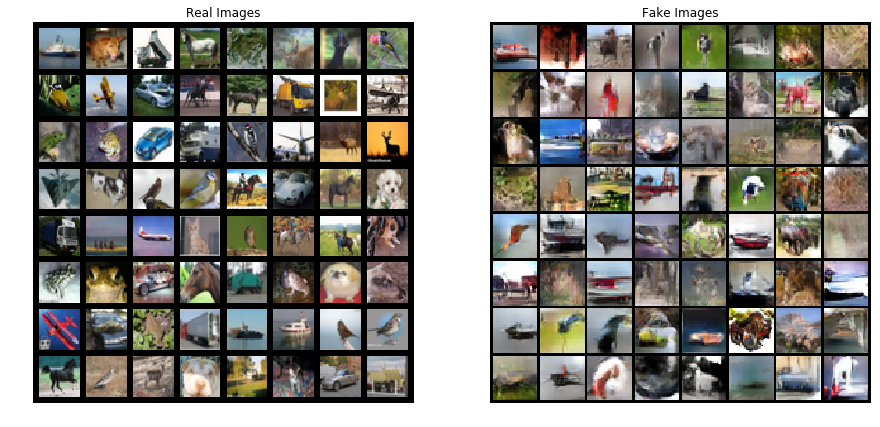

In [13]:
# 从数据加载器中获取一批真实图像
real_batch = next(iter(dataloader))

# 画出真实图像
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 画出来自最后一次训练的假图像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


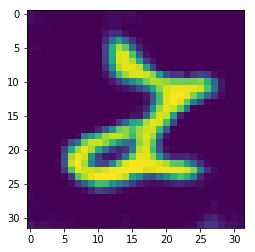

In [51]:
torch.save(netG.state_dict(), "C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-models\\CGAN-Clear-Generator-MaxLogVar48-epoch60-Fashion_MNIST-6\\netG_params.pkl")
torch.save(netD.state_dict(), "C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-models\\CGAN-Clear-Discriminator-MaxLogVar48-epoch60-Fashion_MNIST-6\\netD_params.pkl")
noise = torch.randn(b_size, nz, device=device)
        
labels_onehot = np.zeros((b_size,10))
labels_onehot[np.arange(b_size),2]=1 # 这个9换成想生成的数字
noise=np.concatenate((noise.cpu().numpy(), labels_onehot),axis=1)
# 每张图片是0到9之间的数字
labels_onehot = Variable(torch.from_numpy(labels_onehot).float()).to(device)
noise=noise.reshape([-1, 110, 1, 1])
# print(noise.shape)
noise=Variable(torch.from_numpy(noise).float()).to(device)

# 使用生成器G生成假图片
fake = netG(noise)
# fake = torch.squeeze((fake),0)
# print(fake.shape)
plt.imshow(fake.cpu().detach().numpy()[5][0])